# Dino Fun World Anaylsis

You, in your role as a burgeoning data explorer and visualizer, have been asked by the administrators of a small amusement park in your hometown to answer a couple questions about their park operations. In order to perform the requested analysis, they have provided you with a database containing information about one day of the park's operations.

### Provided Database

The database provided by the park administration is formatted to be readable by any SQL database library. The course staff recommends the sqlite3 library. The database contains three tables, named 'checkins', 'attractions', and 'sequences'. The information contained in each of these tables is listed below:

`checkins`:
    - Description: check-in data for all visitors for the day in the park. The data includes two types of check-ins, inferred and actual checkins.
    - Fields: visitorID, timestamp, attraction, duration, type

`attraction`:
    - The attractions in the park by their corresponding AttractionID, Name, Region, Category, and type. Regions are from the VAST Challenge map such as Coaster Alley, Tundra Land, etc. Categories include Thrill rides, Kiddie Rides, etc. Type is broken into Outdoor Coaster, Other Ride, Carussel, etc.
    - Fields: AttractionID, Name, Region, Category, type
    
`sequences`:
    - The check-in sequences of visitors. These sequences list the position of each visitor to the park every five minutes. If the visitor has not entered the part yet, the sequence has a value of 0 for that time interval. If the visitor is in the park, the sequence lists the attraction they have most recently checked in to until they check in to a new one or leave the park.
    - Fields: visitorID, sequence
    
The database is named 'dinofunworld.db' and is located in the 'readonly' directory of the Jupyter Notebook environment. It can be accessed at 'readonly/dinofunworld.db'.

### Questions to Answer

The administrators would like you to answer four relatively simple questions about the park activities on the day in question. These questions all deal with park operations and can be answered using the data provided.

Question 1: What is the most popular attraction to visit in the park?

Question 2: What ride (note that not all attractions are rides) has the longest visit time?

Question 3: Which Fast Food offering has the fewest visitors?

Question 4: Compute the Skyline of number of visits and visit time for the park's ride and report the rides that appear in the Skyline.

Question 5: A Pie Chart depicting visits to thrill ride attractions.

Question 6: A Bar Chart depicting total visits to food stalls.

Question 7: A Line Chart depicting attendance at the newest ride, Atmosfear over the course of the day.

Question 8: A Box-and-Whisker Plot depicting total visits to the park's Kiddie Rides.

Question 9: The park's administrators would like you to help them understand the different paths visitors take through the park and different rides they visit. In this mission, they have selected 5 visitors at random whose checkin sequences they would like you to analyze. For now, they would like you to construct a distance matrix for these 5 visitors. The five visitors have the ids: 165316, 1835254, 296394, 404385, and 448990.

Question 10: The park's administrators would like to understand the attendance dynamics at each ride (note that not all attractions are rides). They would like to see the minimum (non-zero) attendance at each ride, the average attendance over the whole day, and the maximum attendance for each ride on a Parallel Coordinate Plot.

Question 11: In addition to a PCP, the administrators would like to see a Scatterplot Matrix depicting the min, average, and max attendance for each ride as above.

Question 12: The park's administrators are worried about the attendance at the ride 'Atmosfear' in the data window. To assuage their fears, they have asked you to create a control chart of the total attendance at this ride. Using the data provided, create a control chart displaying the attendance, the mean, and the standard deviation bands at one and two standard deviations.

Question 13: Some of the park's administrators are having trouble interpreting the control chart graph of 'Atmosfear' attendance, so they ask you to also provide a moving average chart of the attendance in addition to the control chart created in the previous question. In this case, they request that you use 50 samples for the size of the moving average window.

Question 14: In order to have options concerning the graphs presented, the park's administrators also ask you to provide a 50-sample moving average window with the average computed with exponential weighting (i.e. an exponentially-weight moving average) over the same 'Atmosfear' attendance dat.

Question 15: Generate a dendrogram graph. Create this dendrogram using the trajectories of the visitors with the IDs: 165316, 1835254, 296394, 404385, and 448990.


In [ ]:
import sqlite3
from datetime import timedelta
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
con = sqlite3.connect('/content/dinofunworld.db')
cur = con.cursor()

In [ ]:
# Question 1: What is the most popular attraction to visit in the park?

cur.execute("SELECT attraction, COUNT(*) as c FROM checkin GROUP BY attraction ORDER BY c desc;")
popular_attraction_id = cur.fetchall()[0][0]
cur.execute("SELECT Name FROM attraction WHERE AttractionID="+str(popular_attraction_id)+";")
popular_attraction = cur.fetchone()[0]
print(popular_attraction)

Atmosfear


In [ ]:
# Question 2: What ride (note that not all attractions are rides) has the longest average visit time?

cur.execute("SELECT AttractionID, Name FROM attraction where LOWER(Category) LIKE '%ride%';")
attraction_name_category_list = cur.fetchall()
ride_time_tuple = ("", 0)
for (aid, name) in attraction_name_category_list:
    cur.execute("SELECT duration FROM checkin where attraction="+str(aid)+";")
    duration_list = cur.fetchall()
    total_dur = 0
    n = 0
    for duration in duration_list:
        try:
            dur = duration[0].split(':')
            total_dur += timedelta(int(dur[0]), int(dur[1]), int(dur[2])).total_seconds()
            n += 1
        except:
            continue
    avg_dur = total_dur / n
    if avg_dur > ride_time_tuple[1]:
        ride_time_tuple = (name, avg_dur)
print(ride_time_tuple[0])

Flight of the Swingodon


In [ ]:
# Question 3: Which Fast Food offering in the park has the fewest visitors?

cur.execute("SELECT attraction, COUNT(*) as c FROM checkin WHERE attraction IN (SELECT AttractionID FROM attraction where LOWER(type) LIKE '%fast food%') GROUP BY attraction ORDER by c asc;")
attraction_id = cur.fetchall()[0][0]
cur.execute("SELECT Name FROM attraction where AttractionID = " + str(attraction_id) + ";")
attraction_name = cur.fetchone()[0]
print(attraction_name)

Theresaur Food Stop


In [ ]:
# Question 4: Compute the Skyline of number of visits and visit time for the park's ride and

cur.execute("SELECT attraction, COUNT(*) as c FROM checkin WHERE attraction IN (SELECT AttractionID FROM attraction where LOWER(Category) LIKE '%ride%') GROUP BY attraction;")
visit_list = cur.fetchall()
best_visited_tuple = (0, 0)
best_ride_time_tuple = (0, math.inf)
best_both_tuple = (0, 0, math.inf)
for (aid,count) in visit_list:
    cur.execute("SELECT duration FROM checkin where attraction="+str(aid)+";")
    duration_list = cur.fetchall()
    total_dur = 0
    n = 0
    for duration in duration_list:
        try:
            dur = duration[0].split(':')
            total_dur += timedelta(int(dur[0]), int(dur[1]), int(dur[2])).total_seconds()
            n += 1
        except:
            continue
    avg_dur = total_dur / n
    if count > best_visited_tuple[1]:
        best_visited_tuple = (aid, count)
    if avg_dur < best_ride_time_tuple[1]:
        best_ride_time_tuple = (aid, avg_dur)
    if count > best_both_tuple[1] and avg_dur < best_both_tuple[2]:
        best_both_tuple = (aid, count, avg_dur)
cur.execute("SELECT Name FROM attraction WHERE AttractionID="+str(best_visited_tuple[0])+" OR AttractionID="+str(best_ride_time_tuple[0])+" OR AttractionID="+str(best_both_tuple[0])+";")
names = cur.fetchall()
name_list = [name[0] for name in names]
print(name_list)

['Wrightiraptor Mountain', 'Atmosfear', 'Dykesadactyl Thrill']


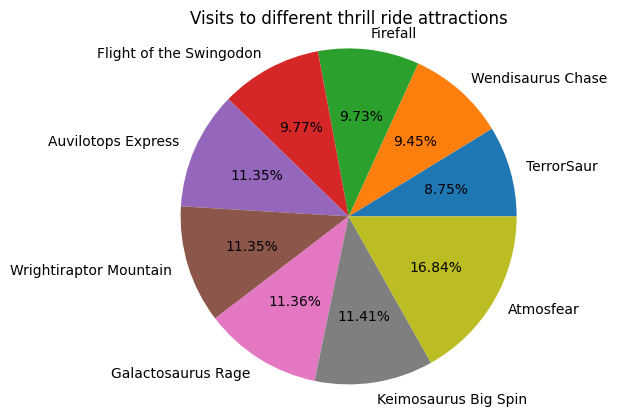

In [ ]:
# Question 5

cur.execute("SELECT attraction.Name, count(checkin.visitorId) as c \
            FROM checkin LEFT JOIN attraction ON checkin.attraction = attraction.AttractionID \
            WHERE LOWER(attraction.Category) LIKE '%thrill%' \
            GROUP BY attraction.Name \
            ORDER BY c;")
count_visits = cur.fetchall()
visit_stats = pd.DataFrame.from_records(count_visits, columns=['RideName', 'VisitCount'])
plt.pie(visit_stats['VisitCount'], labels=visit_stats['RideName'], autopct='%0.2f%%', shadow=False)
plt.axis('equal')
plt.title('Visits to different thrill ride attractions')
plt.show()


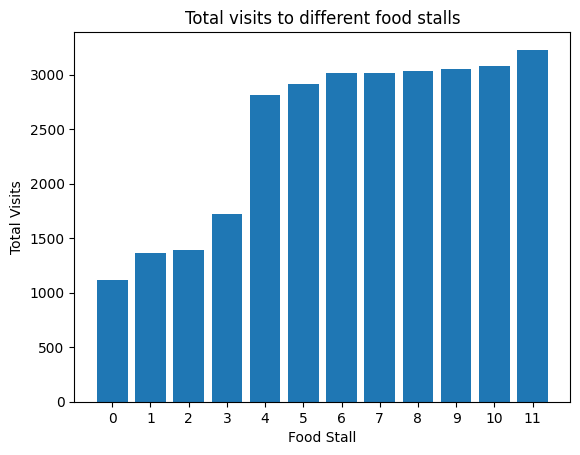

In [ ]:
# Question 6
cur.execute("SELECT attraction.Name, count(checkin.visitorId) as c \
            FROM checkin LEFT JOIN attraction ON checkin.attraction = attraction.AttractionID \
            WHERE LOWER(attraction.Category) LIKE '%food%' \
            GROUP BY attraction.Name \
            ORDER BY c;")
count_visits = cur.fetchall()
visit_stats = pd.DataFrame.from_records(count_visits, columns=['FoodStallName', 'VisitCount'])
plt.bar(range(len(visit_stats['FoodStallName'])), visit_stats['VisitCount'])
plt.ylabel('Total Visits')
plt.xlabel('Food Stall')
plt.xticks([x for x in range(len(visit_stats['FoodStallName']))])
plt.title('Total visits to different food stalls')
plt.show()


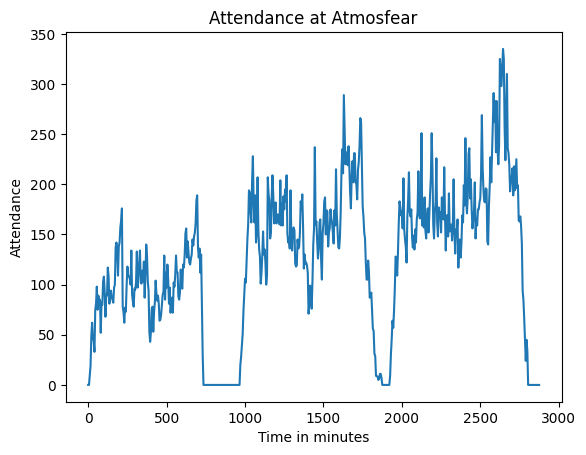

In [ ]:
# Question 7
cur.execute("SELECT attractionId, Name FROM attraction where attraction.Name = 'Atmosfear';")
attractionID = cur.fetchone()[0]
cur.execute("SELECT visitorID, sequence FROM sequences where sequence LIKE '%" + str(attractionID) + "%';")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'] \
.apply(lambda s: [1 if x == str(attractionID) else 0 for x in s.split("-")])
attendance = np.sum(sequence_stats['sequence_list'].values.tolist(), axis=0)
x_axis_list = range(0, len(attendance)*5, 5)
plt.plot(x_axis_list, attendance)
plt.ylabel('Attendance')
plt.xlabel('Time in minutes')
plt.title('Attendance at Atmosfear')
plt.show()
result = [[x_axis_list[i], attendance[i]] for i in range(len(x_axis_list))]



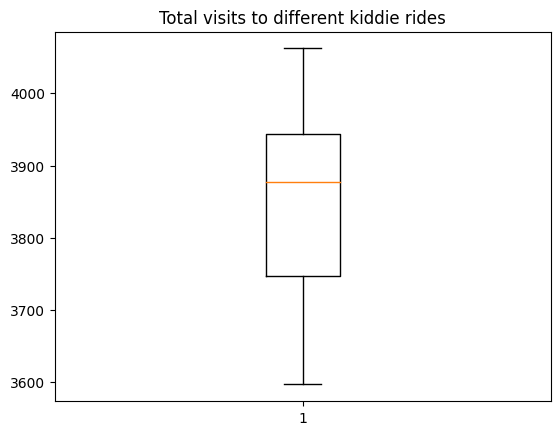

In [ ]:
# Question 8
cur.execute("SELECT attraction.Name, count(checkin.visitorId) as c \
            FROM checkin LEFT JOIN attraction ON checkin.attraction = attraction.AttractionID \
            WHERE LOWER(attraction.Category) LIKE '%kiddie%' \
            GROUP BY attraction.Name \
            ORDER BY c;")
count_visits = cur.fetchall()
visit_stats = pd.DataFrame.from_records(count_visits, columns=['KiddieRideName', 'VisitCount'])
plt.boxplot(visit_stats['VisitCount'])
plt.title('Total visits to different kiddie rides')
plt.show()


In [ ]:
# Question 9
cur.execute("SELECT visitorID, sequence FROM sequences where visitorID IN (165316, 1835254, 296394, 404385, 448990);")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'].apply(lambda s: s.split("-"))
outer_dict = {}
for i in range(5):
    for j in range(i+1, 5):
        dist = sum(int(v1) != int(v2) for v1, v2 in zip(sequence_stats['sequence_list'][i], sequence_stats['sequence_list'][j]))
        id_i = sequence_stats['visitor'][i]
        id_j = sequence_stats['visitor'][j]
        innerDict_i = outer_dict.get(id_i, {})
        innerDict_i[id_j] = dist
        outer_dict[id_i] = innerDict_i
        innerDict_j = outer_dict.get(id_j, {})
        innerDict_j[id_i] = dist
        outer_dict[id_j] = innerDict_j
print(outer_dict)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


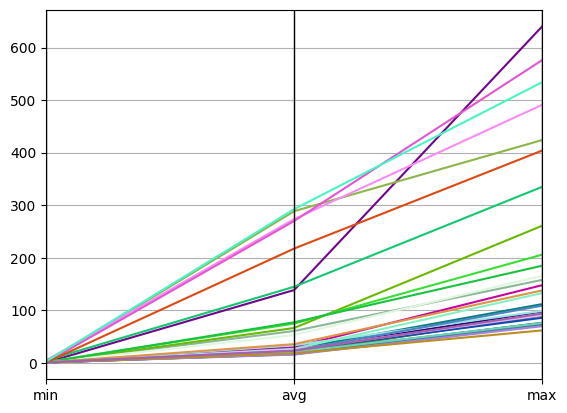

In [ ]:
# Question 10
cur.execute("SELECT AttractionID, Name FROM attraction where LOWER(Category) LIKE '%ride%';")
attraction_name_category_list = cur.fetchall()
attractions = pd.DataFrame.from_records(attraction_name_category_list, columns=['attractionID', 'attractionName'])
cur.execute("SELECT visitorID, sequence FROM sequences;")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'].apply(lambda s: s.split("-"))
outer_dict_q2 = {}
new_col_name = "sequence_list_attendance"
for i in range(len(attraction_name_category_list)):
    sequence_stats[new_col_name] = sequence_stats['sequence_list'] \
    .apply(lambda s: [1 if int(x) == int(attraction_name_category_list[i][0]) else 0 for x in s])
    attendance = np.sum(sequence_stats[new_col_name].values.tolist(), axis=0)
    attendance = attendance[np.nonzero(attendance)]
    min_attendance = np.min(attendance)
    avg_attendance = np.mean(attendance)
    max_attendance = np.max(attendance)
    inner_dict_q2 = {"min": min_attendance, "avg": avg_attendance, "max": max_attendance}
    outer_dict_q2[attraction_name_category_list[i][1]] = inner_dict_q2
output_frame_q2 = pd.DataFrame.from_dict(outer_dict_q2, orient='index')
output_frame_q2 = output_frame_q2.reset_index()
output_frame_q2.columns = ['ride' if x=='index' else x for x in output_frame_q2.columns]
pd.plotting.parallel_coordinates(output_frame_q2, 'ride')
plt.gca().legend_.remove()
plt.show()


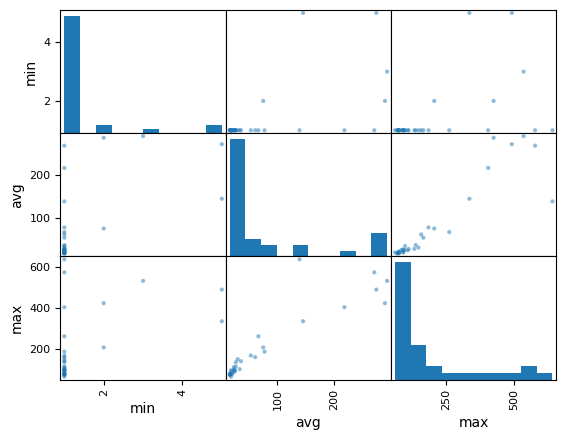

In [ ]:
# Question 11
pd.plotting.scatter_matrix(output_frame_q2)
plt.show()


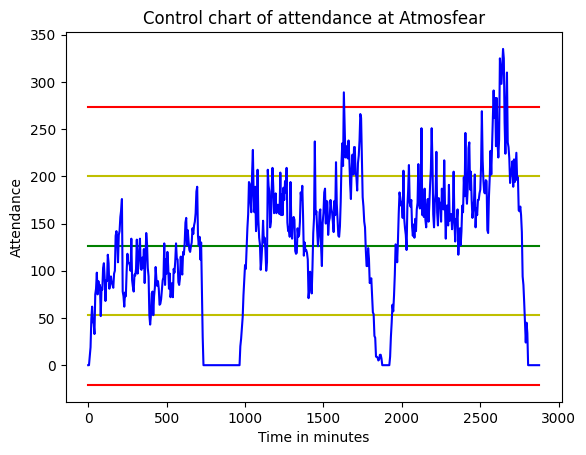

Mean = 126.359375, Standard Deviation = 73.63511071604992


In [ ]:
# Question 12
cur.execute("SELECT attractionId, Name FROM attraction where attraction.Name = 'Atmosfear';")
attractionID = cur.fetchone()[0]
cur.execute("SELECT visitorID, sequence FROM sequences where sequence LIKE '%" + str(attractionID) + "%';")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'] \
.apply(lambda s: [1 if x == str(attractionID) else 0 for x in s.split("-")])
attendance = np.sum(sequence_stats['sequence_list'].values.tolist(), axis=0)
#print(attendance)
mean = np.nanmean(attendance)
std = np.nanstd(attendance)
x_axis_list = range(0, len(attendance)*5, 5)
plt.plot(x_axis_list, [mean+2*std]*len(attendance), 'r-')
plt.plot(x_axis_list, [mean-2*std]*len(attendance), 'r-')
plt.plot(x_axis_list, [mean+std]*len(attendance), 'y-')
plt.plot(x_axis_list, [mean-std]*len(attendance), 'y-')
plt.plot(x_axis_list, [mean]*len(attendance), 'g-')
plt.plot(x_axis_list, attendance, 'b-')
plt.ylabel('Attendance')
plt.xlabel('Time in minutes')
plt.title('Control chart of attendance at Atmosfear')
plt.show()
print("Mean = " + str(mean) + ", Standard Deviation = " + str(std))

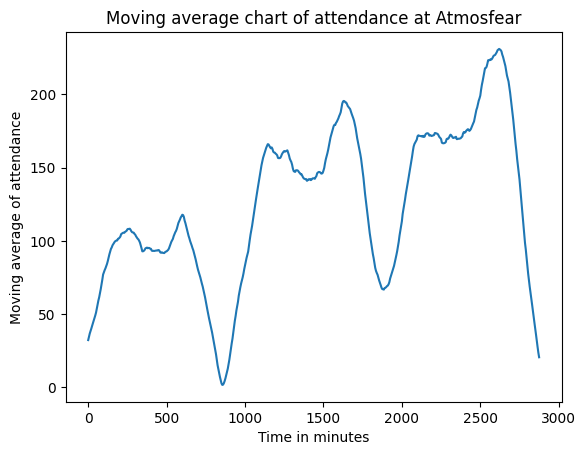

In [ ]:
# Question 13
window_size = 50
plt.plot(x_axis_list, np.convolve(attendance, np.ones(window_size,)/window_size, 'same'), )
plt.ylabel('Moving average of attendance')
plt.xlabel('Time in minutes')
plt.title('Moving average chart of attendance at Atmosfear')
plt.show()


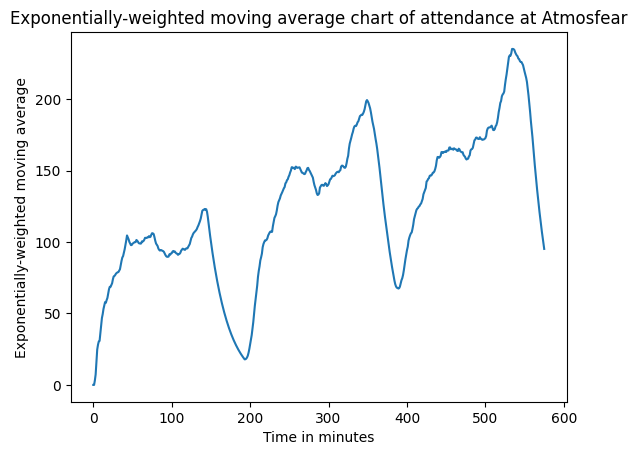

In [ ]:
# Question 14
span = 50
df = pd.DataFrame(data=attendance)
df_exp = df.ewm(span=span).mean()
plt.plot(df_exp)
plt.ylabel('Exponentially-weighted moving average')
plt.xlabel('Time in minutes')
plt.title('Exponentially-weighted moving average chart of attendance at Atmosfear')
plt.show()

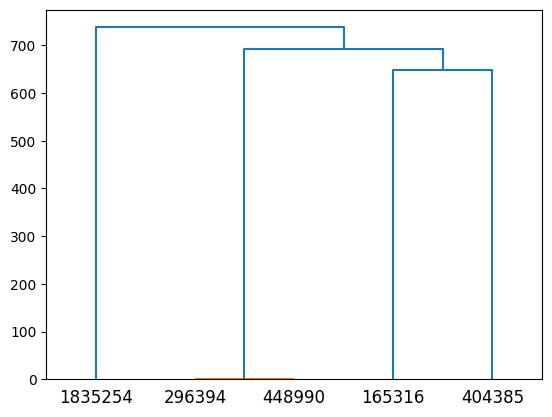

In [ ]:
# Question 15
cur.execute("SELECT visitorID, sequence FROM sequences where visitorID IN (165316, 1835254, 296394, 404385, 448990);")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'].apply(lambda s: [int(x) for x in s.split("-")])
np_mat = np.matrix(sequence_stats['sequence_list'].values.tolist())
links = linkage(np_mat, 'average')
dendrogram(links, labels=sequence_stats['visitor'].values.tolist())
plt.show()